In [1]:
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import re
import ast
import string
import unidecode
from collections import defaultdict
from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Embedding, concatenate, Input, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from nltk import word_tokenize
from nltk.corpus import stopwords

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
from sklearn import metrics

In [3]:
with open("../data/word2idx/word2idx.pkl", "rb") as f:
    word2idx = pickle.load(f)
    #Map any unknown word to UNKNOWN, which has index 1

In [4]:
len(word2idx)

445881

In [5]:
data = pd.read_csv('../data/sample_data_1percent.csv')

In [6]:
conditions = data.link_anchor.str.contains('#', na=False)
data = data[~conditions]
data = data.reset_index().drop('index', axis=1)

print(data.shape)
display(data.head())

(2459381, 7)


,text,link_anchor,link_start,link_end,target_wikidata,tokenized_vector,candidates
0,the academy awards also officially and popular...,film industry,120,133,1415395,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[93196.0, 2973146.0, 2973208.0, 2973157.0, 328..."
1,the academy awards also officially and popular...,academy of motion picture arts and sciences,156,199,212329,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[212329.0, 212329.0]"
2,the academy awards also officially and popular...,art deco,551,559,173782,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[173782.0, 4824850.0, 4796770.0, 23307613.0, 2..."
3,the academy awards also officially and popular...,george stanley,603,617,5544783,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[3101928.0, 5539480.0, 5544780.0, 5544779.0, 5..."
4,the academy awards also officially and popular...,cedric gibbons,642,656,727904,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[727904.0, 5057103.0]"


In [ ]:
import spacy
nlp = spacy

In [9]:
# get necessary data
with open('../data/knowledge_graph_data/id2text_entity.pickle', 'rb') as f:
    id2text = pickle.load(f)
    
with open('../data/name_to_wiki_id.pkl', 'rb') as f:
    name_to_wiki_id = pickle.load(f)
    
with open('../data/knowledge_graph_data/idx2id_entity.pickle', 'rb') as f:
    idx2id = pickle.load(f)
    
id2idx = {value: key for key, value in idx2id.items()}

graph_embedding = np.load('../data/knowledge_graph_data/wiki_DistMult_entity.npy') 

In [11]:
#window length actually 2 times this since from both sides
window_length = 10

In [16]:
#window length actually 2 times this since from both sides
window_length = 10

#For each of the entities in each of the rows, make word2idx vector using context window and also get graph embedding.
try:
    lstm_input_list = np.load("../data/model1/lstm_input_list.npy", allow_pickle = True)
    graph_input_list = np.load("../data/model1/graph_input_list.npy", allow_pickle = True)
except FileNotFoundError:


    lstm_input_list = []
    # corresponds to each candidate
    graph_input_list = []

    for i, article in tqdm_notebook(data.iterrows(), total = len(data)):
        text = article['text']
    #     doc_embedding = docs[i][0]
    #     for entity, indices in article[1].items():
        name = article['link_anchor']
        entity_id = article['target_wikidata']
        #Don't include actual entity text for now in context window since doing fixed length? 
        indices = np.array([int(c) for c in list(article['tokenized_vector']) if c.isdigit()])
        entity_idx = np.where(indices == 1)[0]
        if len(entity_idx):
            split_text = text.split()
            context = split_text[max(0, entity_idx.min() - window_length) : entity_idx.min()] +\
                      split_text[entity_idx.max() + 1 : entity_idx.max() + window_length + 1] 
            #if word not in vocab, by default map to 1
            context_word2idx = [word2idx.get(word, 1) for word in context]
        
            #storing list of candidates in knowledge graph
            kge_candidates = []
        
            #get a candidate from candidate_dict to get a false, irrelevant entity for each entity
            if not pd.isnull(article['candidates']):
                candidates_list = ast.literal_eval(article['candidates'])[:10]
                #can't choose actual entity as false 
                if entity_id in candidates_list:
                    candidates_list.remove(entity_id)
                if len(candidates_list) > 0:
                    for false_entity_id in candidates_list:
                        if false_entity_id in id2idx:
                            false_graph_embed = graph_embedding[id2idx[false_entity_id]]
                            #lstm_input.append(context_word2idx)
                            #graph_input.append(false_graph_embed)
            #                 doc_input.append(doc_embedding)
                            #response.append(0)
                            kge_candidates.append(false_graph_embed)
                        else:
                            pass
                            #not_in_graph.append(false_entity_id)
            if entity_id in id2idx:
                true_graph_embed = graph_embedding[id2idx[entity_id]]
                #lstm_input.append(context_word2idx)
                #graph_input.append(true_graph_embed)
        #         doc_input.append(doc_embedding)
                #response.append(1)
                # this means that last index is always the true embedding
                kge_candidates.append(true_graph_embed)
                lstm_input_list.append(context_word2idx)
                graph_input_list.append(np.array(kge_candidates))
        
            else:
                pass
                #not_in_graph.append(entity_id)
            
    #lstm_input = pad_sequences(lstm_input, maxlen = window_length * 2, padding = 'post')
    # graph_input = np.array(graph_input)
    # # doc_input = np.array(doc_input)
    # response = np.array(response)
    
    lstm_input_list = np.array(lstm_input_list)
    graph_input_list = np.array(graph_input_list)
    
    np.save("../data/model1/lstm_input_list.npy", lstm_input_list)
    np.save("../data/model1/graph_input_list.npy", graph_input_list)

NameError: name 'lstm_input' is not defined

In [29]:
# np.save("../data/model1/lstm_input.pkl", lstm_input)
# np.save("../data/model1/graph_input.pkl", graph_input)
# np.save("../data/model1/response.pkl", response)

In [10]:
# lstm_input = np.load("../data/model1/lstm_input.pkl.npy")
# graph_input = np.load("../data/model1/graph_input.pkl.npy")
# response = np.load("../data/model1/response.pkl.npy")

In [15]:
# np.random.seed(1)

# train_ind, test_ind = train_test_split(np.arange(len(response)))
# lstm_train = lstm_input[train_ind]
# lstm_test = lstm_input[test_ind]
# graph_train = graph_input[train_ind]
# graph_test = graph_input[test_ind]
# # doc_train = doc_input[train_ind]
# # doc_test = doc_input[test_ind]
# y_train = response[train_ind]
# y_test = response[test_ind]

# len(y_train), len(y_test)

(8844793, 2948265)

In [6]:
# train test split
np.random.seed(1)

train_idx, test_idx = train_test_split(np.arange(len(lstm_input_list)), test_size=0.2)

print('Training Set Size: {}, Test Set Size: {}'.format(len(train_idx), len(test_idx)))

In [28]:
def build_data(lstm_input_list, graph_input_list, indices):
    # construct lstm, graph set based on indices
    lstm_data = []
    graph_data = []
    response = []
    for ind in indices:
        lstm_inp = lstm_input_list[ind]
        graph_inp = graph_input_list[ind]
        for i, kge in enumerate(graph_inp):
            lstm_data.append(lstm_inp)
            graph_data.append(kge)
            if i == len(graph_inp)-1:
                response.append(1)
            else:
                response.append(0)
    lstm_data = np.array(lstm_data)
    lstm_data = pad_sequences(lstm_data, maxlen = window_length * 2, padding = 'post')
    graph_data = np.array(graph_data)
    response = np.array(response)

    return lstm_data, graph_data, response

In [12]:
lstm_train, graph_train, y_train = build_data(lstm_input_list, graph_input_list, train_idx)
lstm_test, graph_test, y_test = build_data(lstm_input_list, graph_input_list, test_idx)

In [30]:
weights = class_weight.compute_class_weight('balanced',
                                            np.unique(y_train),
                                            y_train)

In [21]:
inp1 = Input(shape = (lstm_train.shape[1], ))
inp2 = Input(shape = (graph_train.shape[1], ))
# inp3 = Input(shape = (doc_input.shape[1], ))
embed = Embedding(output_dim=100, input_dim=len(word2idx), input_length=lstm_train.shape[1])(inp1)
out1 = LSTM(128)(embed)
w = concatenate([out1, inp2])
w = Dense(256, activation = 'relu')(w)
w = Dropout(0.2)(w)
out = Dense(1, activation = 'sigmoid')(w)
model = Model(inputs=[inp1, inp2], outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

W1111 20:41:45.244285 140108875978560 deprecation_wrapper.py:119] From /home/matteo/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1111 20:41:45.705070 140108875978560 deprecation_wrapper.py:119] From /home/matteo/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1111 20:41:45.714592 140108875978560 deprecation.py:506] From /home/matteo/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W1111 20:41:45.753077 140108875978560 deprecation_wrapper.py:119] From /home/matteo/.local/lib/py

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 100)      44588100    input_3[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128)          117248      embedding_1[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 250)          0                                            
__________________________________________________________________________________________________
concatenat

In [95]:
# model.fit([lstm_train, graph_train, doc_train], y_train, batch_size = 256, epochs = 3, validation_split = 0.2)
model.fit([lstm_train, graph_train], y_train, batch_size = 8192, epochs = 4, validation_split = 0.2, class_weight = weights)

Train on 7490784 samples, validate on 1872697 samples
Epoch 1/4
7490784/7490784 [==============================] - 118s 16us/step - loss: 0.3947 - acc: 0.8275 - val_loss: 0.3468 - val_acc: 0.8453
Epoch 2/4
7490784/7490784 [==============================] - 117s 16us/step - loss: 0.3301 - acc: 0.8515 - val_loss: 0.3178 - val_acc: 0.8581
Epoch 3/4
7490784/7490784 [==============================] - 117s 16us/step - loss: 0.2974 - acc: 0.8653 - val_loss: 0.3062 - val_acc: 0.8641
Epoch 4/4
7490784/7490784 [==============================] - 117s 16us/step - loss: 0.2727 - acc: 0.8761 - val_loss: 0.3031 - val_acc: 0.8661


In [96]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])
y_test_pred_prob = model.predict([lstm_test, graph_test])

y_test_pred = np.where(y_test_pred_prob > 0.5, 1, 0)
accuracy_score(y_test, y_test_pred)

0.8662181277972191

In [97]:
cm = confusion_matrix(y_test, y_test_pred)

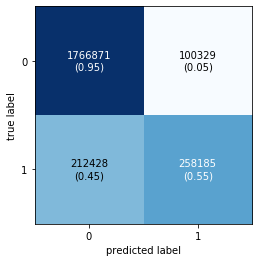

In [98]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(cm, show_normed = True);

In [99]:
metrics.roc_auc_score(y_test, y_test_pred_prob)

0.8992317949581741

In [100]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_test_pred_prob)

Text(0.5, 1.0, 'ROC curve')

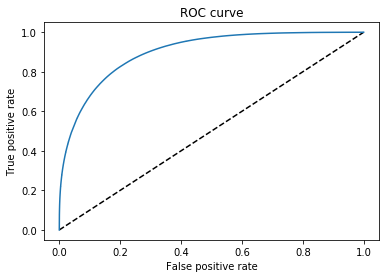

In [101]:
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [47]:
# see prediction score on candidate list

# find cutoff
# offset of where the true index is
cutoffs = [0]
for ind in test_idx:
    graph_inp = graph_input_list[ind]
    cutoffs.append(cutoffs[-1] + len(graph_inp))

In [174]:
candidate_test_acc = .0
count = len(cutoffs) - 1
print_count = 100
for start_idx, end_idx in zip(cutoffs, cutoffs[1:]):
    probs = y_test_pred_prob[start_idx:end_idx]
    #if np.argmax(probs) == len(probs) - 1:
    if max(probs) == probs[-1]:
        if np.random.randint(sum(probs == probs[-1])) == 0:
            candidate_test_acc += 1
    else:
        if print_count:
            print(probs[-1], max(probs))
            print_count -= 1
candidate_test_acc /= count

[0.01729989] [0.02396834]
[0.32298976] [0.3544377]
[0.18044725] [0.2968958]
[0.28315234] [0.28633875]
[0.08612305] [0.31351438]
[0.55070865] [0.6028807]
[0.35431233] [0.5716927]
[0.19054782] [0.37446225]
[0.13249263] [0.54841304]
[0.32559013] [0.58030134]
[0.28484526] [0.83727324]
[0.2629851] [0.40478578]
[0.08219287] [0.5176184]
[0.12858799] [0.1606648]
[0.50938183] [0.73565733]
[0.44300902] [0.5855285]
[0.363913] [0.4488064]
[0.7684406] [0.87551075]
[0.54154724] [0.5485639]
[0.20312539] [0.35756332]
[0.19594243] [0.20610839]
[0.5074946] [0.56297266]
[0.2570477] [0.257521]
[0.23742947] [0.64808106]
[0.0569424] [0.30480427]
[0.2340967] [0.2588004]
[0.12902698] [0.67055833]
[0.38749236] [0.73769647]
[0.06655031] [0.56181115]
[0.40871948] [0.44199568]
[0.18334278] [0.19862235]
[0.39908248] [0.5068826]
[0.33775038] [0.42255723]
[0.27888238] [0.28611928]
[0.72619474] [0.7747072]
[0.48645335] [0.6405939]
[0.05742076] [0.16479048]
[0.03145665] [0.65452254]
[0.5342952] [0.7593354]
[0.18748692

In [176]:
candidate_test_acc

0.749747669528891